In [1]:
import pandas as pd
import numpy as np
import networkx as nx

import re
import itertools
import matplotlib
import time
import json

from deep_translator import GoogleTranslator
from deep_translator.exceptions import RequestError
from urllib3.exceptions import ProtocolError
# from ssl.exceptions import ConnectionAbortedError
from requests.exceptions import ChunkedEncodingError
from tqdm.notebook import tqdm
from collections import defaultdict

In [2]:
users = pd.read_csv("table1_user.txt", delimiter="\t")
users.head()

,user_id,live_city_id,desire_jd_city_id,desire_jd_industry_id,desire_jd_type_id,desire_jd_salary_id,cur_industry_id,cur_jd_type,cur_salary_id,cur_degree_id,birthday,start_work_date,experience
0,17e1b9f107dd1214bd78dec6d91593a4,551,"551,-,-",房地产/建筑/建材/工程,工程造价/预结算,100002000,房地产/建筑/建材/工程,土木/建筑/装修/市政工程,0200104000,大专,24,2017,停车|现场|凤凰|预算编制|建设|实习|专家|公园|预算软件|勘察|合同|知识|商务|单位|...
1,0c02d9411e83ae0308cdc40700385d4c,763,"763,-,-",其他,化妆师,400106000,房地产/建筑/建材/工程,后期制作,0400106000,大专,24,2015,调色员|彩妆|护肤|布料|光源|客户|调色
2,1f4504451a08e1e99e0b394e03f24b43,530,"530,-,-","专业服务/咨询(财会/法律/人力资源等),教育/培训/院校","项目经理/项目主管,教学/教务管理人员,翻译（口译与笔译）",0,教育/培训/院校,项目管理/项目协调,1000115000,本科,33,2010,互联网参考模型osi七层|建设|英语|项目主管|签证|谈判|合同|crm系统|pl/sql|...
3,127b43572875dea9ed858da73a651433,871,"5085,-,-",房地产/建筑/建材/工程,行政/后勤/文秘,200104000,旅游/度假,行政/后勤/文秘,0200104000,大专,24,2017,行政|酒店|后勤|温泉|文员|文秘|旅游
4,15c607e1798305fb9f2e525d964a1185,530,"530,-,-","礼品/玩具/工艺美术/收藏品/奢侈品,教育/培训/院校,媒体/出版/影视/文化传播","艺术/设计,教育/培训",600108000,广告/会展/公关,艺术/设计,0600108000,大专,24,2015,上色|产品开发|插画|纸张|老师|制作|3dmax|美术|视觉设计|视觉|vi|道具|设计师...


In [3]:
jds = pd.read_csv("table2_jd.txt", delimiter="\t", on_bad_lines="skip")
jds.head()

C:\Users\roans\AppData\Local\Temp\ipykernel_26200\773696781.py:1: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  jds = pd.read_csv("table2_jd.txt", delimiter="\t", on_bad_lines="skip")


,jd_no,jd_title,company_name,city,jd_sub_type,require_nums,max_salary,min_salary,start_date,end_date,is_travel,min_years,key,min_edu_level,max_edu_level,is_mangerial,resume_language_required,job_description
0,3cf395f1d6f12de112d118c0349acbcd,景观主创设计师,-,530,园林/景观设计,2,25000,15000,20190325,20190524,1,510,NaN,本科,\N,\N,\N,岗位职责：1、全面负责景观项目的概念设计和方案设计、扩初设计和施工图设计的工作，同时对方案文...
1,4ce99de185f55bea127ccd74c4bbf0ad,土建工程造价员,-,551,工程造价/预结算,5,8000,4000,20190313,20190412,1,305,NaN,大专,\N,\N,NaN,1、能够独立完成工程概、预、结算的编制及审核工作；2、熟悉重庆地区相关计价原则及计价文件；3...
2,d1181ba44c2cba01523b143dbf264636,汽车销售,-,719,汽车销售,5,10000,8001,20190301,20190410,1,-1,NaN,\N,\N,\N,NaN,岗位职责：1、负责整车销售服务和进店客户咨询服务；2、负责整理各车型的销售资料及客户档案；3...
3,4e5da61aeffaba3dfea3bdd09dcce8d9,客服文员/网络客服5000＋,-,565,网络/在线客服,10,8000,4000,20190220,20191217,0,-1,NaN,\N,\N,\N,NaN,高薪线上推广专员（可接受优秀应届毕业生）岗位职责：1、为客户提供快速、准确与专业的咨询及服务...
4,db4d4ce28d394344a4bf93c18242e7d2,中安华筑技术标专员（五险+双休+早九晚五）,-,664,工程造价/预结算,5,6000,4001,20190318,20190417,0,103,NaN,大专,\N,\N,NaN,岗位职责：1、负责组织招标文件、投标文件的审批工作；2、参与投标活动，负责投标答辩资料的编纂...


In [4]:
actions = pd.read_csv("table3_action.txt", delimiter="\t")
actions.head()

,user_id,jd_no,browsed,delivered,satisfied
0,17e1b9f107dd1214bd78dec6d91593a4,4ce99de185f55bea127ccd74c4bbf0ad,0,0,0
1,17e1b9f107dd1214bd78dec6d91593a4,e9959d3b5fd8b26da07e8b8a3b80489a,0,0,0
2,17e1b9f107dd1214bd78dec6d91593a4,7ecd6ab0c7e43b40b7d1dbd4a9b1e6f5,0,0,0
3,17e1b9f107dd1214bd78dec6d91593a4,112ea9c8ef92c1a7d5fa679cc6c05053,0,0,0
4,17e1b9f107dd1214bd78dec6d91593a4,1953082bf7ee0919820eb7ba05be3425,0,0,0


In [5]:
uid_to_num = dict(zip(users["user_id"], [f"u{i}" for i in range(len(users))]))
jid_to_num = dict(zip(jds["jd_no"], [f"j{i}" for i in range(len(jds))]))

In [6]:
users["user_id"] = users["user_id"].apply(lambda x: uid_to_num[x])
jds["jd_no"] = jds["jd_no"].apply(lambda x: jid_to_num[x])

actions["user_id"] = actions["user_id"].apply(lambda x: uid_to_num[x])
actions["jd_no"] = actions["jd_no"].apply(lambda x: jid_to_num[x] if x in jid_to_num else x)

In [7]:
user_desire_industry = users[["user_id", "desire_jd_industry_id"]].set_index("user_id").squeeze().replace('[(\（\().*\)]','', regex=True).str.split(r"[/|,、]").explode()
user_desire_type = users[["user_id", "desire_jd_type_id"]].set_index("user_id").squeeze().replace('[(\（\().*\)]','', regex=True).str.split(r"[/|,、]").explode()
user_current_industry = users[["user_id", "cur_industry_id"]].set_index("user_id").squeeze().replace('[(\（\().*\)]','', regex=True).str.split(r"[/|,、]").explode()
user_cur_type = users[["user_id", "cur_jd_type"]].set_index("user_id").squeeze().replace('[(\（\().*\)]','', regex=True).str.split(r"[/|,、]").explode()
user_degree = users[["user_id", "cur_degree_id"]].set_index("user_id").squeeze().replace('[(\（\().*\)]','', regex=True).str.split(r"[/|,、]").explode()
user_experience = users[["user_id", "experience"]].set_index("user_id").squeeze().replace('[(\（\().*\)]','', regex=True).str.split(r"[/|,、]").explode()

In [8]:
jds_sub_type = jds[["jd_no", "jd_sub_type"]].set_index("jd_no").squeeze().replace('[(\（\().*\)]','', regex=True).str.split(r"[/|,、]").explode()
jds_min_degree = jds[["jd_no", "min_edu_level"]].set_index("jd_no").squeeze().replace('[(\（\().*\)]','', regex=True).str.split(r"[/|,、]").explode()
jds_max_degree = jds[["jd_no", "max_edu_level"]].set_index("jd_no").squeeze().replace('[(\（\().*\)]','', regex=True).str.split(r"[/|,、]").explode()

In [9]:
all_values = {i for i in set(user_desire_industry) | set(user_desire_type) | set(user_current_industry) | set(user_cur_type) | set(user_experience) | set(user_degree) | set(jds_sub_type) | set(jds_min_degree) | set(jds_max_degree) if type(i) == str}

In [10]:
def create_translation_dict(values):
    
    translator = GoogleTranslator()
    translations = {}
       
    print(len(values))
        
    for v in tqdm(values):
        if v == "400":
            continue
        try:
            translations[v] = translator.translate(v)
        except (RequestError, ProtocolError, ConnectionAbortedError, ChunkedEncodingError):
            print("RequestError occurred... Sleeping for 10 seconds")
            time.sleep(10)
            try:
                translations[v] = translator.translate(v)
            except :
                translations[v] = v
                            
    return translations

In [11]:
try:
    with open('translation_dict.json') as f:
        translation_dict = json.load(f)
except FileNotFoundError:
    translation_dict = create_translation_dict(all_values)
    json.dumps(translation_dict, "translation_dict.json")

In [12]:
user_desire_industry = user_desire_industry.apply(lambda x: translation_dict[x] if x in translation_dict else x)
user_desire_type = user_desire_type.apply(lambda x: translation_dict[x] if x in translation_dict else x)
user_current_industry = user_current_industry.apply(lambda x: translation_dict[x] if x in translation_dict else x)
user_cur_type = user_cur_type.apply(lambda x: translation_dict[x] if x in translation_dict else x)
user_degree = user_degree.apply(lambda x: translation_dict[x] if x in translation_dict else x)
user_experience = user_experience.apply(lambda x: translation_dict[x] if x in translation_dict else x)

jds_sub_type = jds_sub_type.apply(lambda x: translation_dict[x] if x in translation_dict else x)
jds_min_degree = jds_min_degree.apply(lambda x: translation_dict[x] if x in translation_dict else x)
# jds_max_degree = jds_max_degree.apply(lambda x: translation_dict[x] if x in translation_dict else x) <-- All values are \n

In [13]:
G = nx.DiGraph()

# interactions
interactions = actions[actions[["browsed", "delivered", "satisfied"]].sum(axis=1) >= 1][["user_id", "jd_no"]].values
G.add_edges_from(interactions, label="interactedWith")
G.add_edges_from(interactions[:,::-1], label="interactedBy")

# G.add_edges_from(jds[["jd_no", "company_name"]].astype(str).values, label="postByCompany") <-- All values are -

# Job sub types
sub_types = np.array(list(zip(jds_sub_type.index, jds_sub_type)))
G.add_edges_from(sub_types, label="hasSubType")
G.add_edges_from(sub_types[:,::-1], label="isSubTypeOf")

# Job required degree
min_degrees = np.array(list(zip(jds_min_degree.values, jds_min_degree)))
G.add_edges_from(min_degrees, label="requiresDegree")
G.add_edges_from(min_degrees[:,::-1], label="isRequiredDegreeOf")

# Job max degree
max_degrees = np.array(list(zip(jds_max_degree.values, jds_max_degree)))
G.add_edges_from(max_degrees, label="maxDegree")
G.add_edges_from(max_degrees[:,::-1], label="isMaxDegreeOf")

# User held degree
user_degrees = np.array(list(zip(user_degree.index, user_degree)))
G.add_edges_from(user_degrees, label="hasDegree")
G.add_edges_from(user_degrees[:,::-1], label="isUserDegreeOf")

# User current industry
user_current_industries = np.array(list(zip(user_current_industry.index, user_current_industry)))
G.add_edges_from(user_current_industries, label="inCurrentIndustry")
G.add_edges_from(user_current_industries[:,::-1], label="isCurrentIndustryOf")

# User desired industry
user_desired_industries = np.array(list(zip(user_desire_industry.index, user_desire_industry)))
G.add_edges_from(user_desired_industries, label="wantsIndustry")
G.add_edges_from(user_desired_industries[:,::-1], label="isWantedIndustryOf")

# User current type
user_current_types = np.array(list(zip(user_cur_type.index, user_cur_type)))
G.add_edges_from(user_current_types, label="inCurrentType")
G.add_edges_from(user_current_types[:,::-1], label="isCurrentTypeOf")

# User desired type
user_desired_types = np.array(list(zip(user_desire_type.index, user_desire_type)))
G.add_edges_from(user_desired_types, label="wantsType")
G.add_edges_from(user_desired_types[:,::-1], label="isWantedTypeOf")

# User exprience
user_experiences = np.array(list(zip(user_experience.index, user_experience)))
G.add_edges_from(user_experiences, label="hasSkill")
G.add_edges_from(user_experiences[:,::-1], label="isHeldBy")

### Set job types

In [14]:
nx.set_node_attributes(G, {node: {"node_type" : "job_type", 
                                  "color" : "#fcba03"} for node in set(jds_sub_type.index) | set(jds_sub_type) | 
                           set(user_cur_type.index) | set(user_cur_type) | set(user_desire_type.index) | 
                           set(user_desire_type)})

### Set educations

In [15]:
nx.set_node_attributes(G, {node: {"node_type" : "education",
                                  "color" : "#62fc03"} for node in set(jds_min_degree.values) | set(jds_min_degree) |
                           set(jds_max_degree.values) | set(jds_max_degree) | set(user_degree.index) | set(user_degree)})

### Set industries

In [16]:
nx.set_node_attributes(G, {node: {"node_type" : "industry_type",
                                  "color" : "#03f4fc"} for node in set(user_current_industry.index) | 
                           set(user_current_industry) | set(user_desire_industry.index) | set(user_desire_industry)})

In [17]:
user_attrs = {user : {"experience" : users[users["user_id"] == user]["experience"].values[0],
                      "node_type" : "user",
                      "color" : "#f26884"} for user in users["user_id"].values}

In [18]:
jd_attrs = defaultdict(lambda : defaultdict())

for jd in tqdm(jds.itertuples()):
    jd_attrs[jd[1]]["title"] = jd[2]

jd_attrs = {jd : {"title" : jds[jds["jd_no"] == jd]["jd_title"].values[0],
                  "node_type" : "job",
                  "color" : "#b300ff"} for jd in jds["jd_no"].values}

0it [00:00, ?it/s]

In [19]:
nx.set_node_attributes(G, user_attrs)

In [20]:
nx.set_node_attributes(G, jd_attrs)

In [21]:
all_neighbors = {}

for n in G.nodes:
    all_neighbors[n] = set(G.neighbors(n))

In [22]:
all_neighbors = {k: {i for i in v if not pd.isna(i)} for k, v in all_neighbors.items()}

In [23]:
def k_walk(G, a, b, all_neighbors, k=6, walks=100):
    sub_graph = []
            
    # Number of walks
    for _ in range(walks):
        path = ()
        
        visited = set()
        
        prev_node = a
        old = None
        
        # Length of each walk
        for _ in range(k):
            # Choose a random neighbor of our current node
            candidates = all_neighbors[prev_node]
                        
            if old and len(candidates) > 1:
                candidates = candidates - set(old)
            
            # If we can reach the target from the current node, 
            # do so, as long as that wouldn't create a duplicate path
            if b in candidates and (prev_node, b) not in set(sub_graph):
                next_node = b
            else:
                if candidates:
                    next_node = np.random.choice(list(candidates))
                    
                    if next_node in visited:
                        continue
                    else:
                        visited.add(next_node)                    
                else:
                    break
            
            path += (prev_node, next_node),
            
            # Update
            old = prev_node
            prev_node = next_node
            
            # If we found the target, store
            if next_node == b:
                sub_graph.extend(path)
                break
                
    sg = set(sub_graph)
    sg -= {(a, b)}
    sg -= {(b, a)}
                
    H = G.edge_subgraph(sg)
    
    nx.set_node_attributes(H, {a : {"color" : "#96ff9a"},
                               b : {"color" : "#96ff9a"}})
        
    # TODO: Also include all reverse edges (e.g., subtypeOf instead of hasSubtype)            
    return H

In [24]:
filtered = actions[actions[["browsed", "delivered", "satisfied"]].sum(axis=1) >= 1]
top_users = filtered.groupby("user_id").count().sort_values(by="jd_no", ascending=False).head(1000).index

In [25]:
non_interactions = actions[actions[["browsed", "delivered", "satisfied"]].sum(axis=1) == 0][["user_id", "jd_no"]]

In [26]:
filtered["result"] = filtered[["browsed", "delivered", "satisfied"]].sum(axis=1)

C:\Users\roans\AppData\Local\Temp\ipykernel_26200\2999300476.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered["result"] = filtered[["browsed", "delivered", "satisfied"]].sum(axis=1)


In [27]:
def create_jsons(G, all_neighbors, top_users, non_interactions, filtered,
                 k=10, walks=100, users=(0, 500)):
    
    for i, user in enumerate(top_users[users[0]:users[1]]):
        print(f"{i}/{users[1] - users[0]}")

        misses = non_interactions[non_interactions["user_id"] == user]["jd_no"]
        hits = filtered[filtered["user_id"] == user]

        record = ""

        missed_graphs = defaultdict(lambda : defaultdict(dict))
        hit_graphs = defaultdict(lambda : defaultdict(dict))
        for miss in tqdm(misses.values[:len(hits)]):
            graph = k_walk(G, user, miss, all_neighbors, k=k, walks=walks)
            record += f"{user},{miss},0\n"    
            missed_graphs[miss] = nx.node_link_data(graph)


        for _, hit, _, _, _, score in tqdm(hits.values):
            graph = k_walk(G, user, hit, all_neighbors, k=k, walks=walks)
            record += f"{user},{hit},{score}\n"    
            hit_graphs[hit] = nx.node_link_data(graph)
            
        with open(f"data4/misses/{user}.json", "w") as f1:
            json.dump(missed_graphs, f1)

        with open(f"data4/hits/{user}.json", "w") as f1:
            json.dump(hit_graphs, f1)

        with open(f"data4/ground_truth/{user}.csv", "w") as f1:
            f1.write(record)

In [28]:
create_jsons(G, all_neighbors, top_users, non_interactions, filtered, k=12, walks=30, users=(0, 500))

0/500


  0%|          | 0/435 [00:00<?, ?it/s]

  0%|          | 0/435 [00:00<?, ?it/s]

1/500


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

2/500


  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

3/500


  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

4/500


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

5/500


  0%|          | 0/348 [00:00<?, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

6/500


  0%|          | 0/311 [00:00<?, ?it/s]

  0%|          | 0/311 [00:00<?, ?it/s]

7/500


  0%|          | 0/229 [00:00<?, ?it/s]

  0%|          | 0/304 [00:00<?, ?it/s]

8/500


  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

9/500


  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/266 [00:00<?, ?it/s]

10/500


  0%|          | 0/263 [00:00<?, ?it/s]

  0%|          | 0/263 [00:00<?, ?it/s]

11/500


  0%|          | 0/263 [00:00<?, ?it/s]

  0%|          | 0/263 [00:00<?, ?it/s]

12/500


  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

13/500


  0%|          | 0/245 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

14/500


  0%|          | 0/229 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

15/500


  0%|          | 0/234 [00:00<?, ?it/s]

  0%|          | 0/234 [00:00<?, ?it/s]

16/500


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

17/500


  0%|          | 0/226 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

18/500


  0%|          | 0/214 [00:00<?, ?it/s]

  0%|          | 0/214 [00:00<?, ?it/s]

19/500


  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

20/500


  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

21/500


  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

22/500


  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

23/500


  0%|          | 0/203 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

24/500


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

25/500


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

26/500


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

27/500


  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

28/500


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

29/500


  0%|          | 0/189 [00:00<?, ?it/s]

  0%|          | 0/189 [00:00<?, ?it/s]

30/500


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

31/500


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/187 [00:00<?, ?it/s]

32/500


  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

33/500


  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

34/500


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

35/500


  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

36/500


  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

37/500


  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

38/500


  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

39/500


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

40/500


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

41/500


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

42/500


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

43/500


  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

44/500


  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

45/500


  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

46/500


  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

47/500


  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

48/500


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

49/500


  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

50/500


  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

51/500


  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

52/500


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

53/500


  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

54/500


  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

55/500


  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

56/500


  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

57/500


  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

58/500


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

59/500


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

60/500


  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

61/500


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

62/500


  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

63/500


  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

64/500


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

65/500


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

66/500


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

67/500


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

68/500


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

69/500


  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

70/500


  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

71/500


  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

72/500


  0%|          | 0/146 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

73/500


  0%|          | 0/146 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

74/500


  0%|          | 0/145 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

75/500


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

76/500


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

77/500


  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

78/500


  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

79/500


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

80/500


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

81/500


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

82/500


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

83/500


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

84/500


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

85/500


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

86/500


  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

87/500


  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

88/500


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

89/500


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

90/500


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

91/500


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

92/500


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

93/500


  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

94/500


  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

95/500


  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

96/500


  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

97/500


  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

98/500


  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

99/500


  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

100/500


  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

101/500


  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

102/500


  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

103/500


  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

104/500


  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

105/500


  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

106/500


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

107/500


  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

108/500


  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

109/500


  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

110/500


  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

111/500


  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

112/500


  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

113/500


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

114/500


  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

115/500


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

116/500


  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

117/500


  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

118/500


  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

119/500


  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

120/500


  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

121/500


  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

122/500


  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

123/500


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

124/500


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

125/500


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

126/500


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

127/500


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

128/500


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

129/500


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

130/500


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

131/500


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

132/500


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

133/500


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

134/500


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

135/500


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

136/500


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

137/500


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

138/500


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

139/500


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

140/500


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

141/500


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

142/500


  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

143/500


  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

144/500


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

145/500


  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

146/500


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

147/500


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

148/500


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

149/500


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

150/500


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

151/500


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

152/500


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

153/500


  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

154/500


  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

155/500


  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

156/500


  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

157/500


  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

158/500


  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

159/500


  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

160/500


  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

161/500


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

162/500


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

163/500


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

164/500


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

165/500


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

166/500


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

167/500


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

168/500


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

169/500


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

170/500


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

171/500


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

172/500


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

173/500


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

174/500


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

175/500


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

176/500


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

177/500


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

178/500


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

179/500


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

180/500


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

181/500


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

182/500


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

183/500


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

184/500


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

185/500


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

186/500


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

187/500


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

188/500


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

189/500


  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

190/500


  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

191/500


  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

192/500


  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

193/500


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

194/500


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

195/500


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

196/500


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

197/500


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

198/500


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

199/500


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

200/500


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

201/500


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

202/500


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

203/500


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

204/500


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

205/500


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

206/500


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

207/500


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

208/500


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

209/500


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

210/500


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

211/500


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

212/500


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

213/500


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

214/500


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

215/500


  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

216/500


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

217/500


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

218/500


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

219/500


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

220/500


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

221/500


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

222/500


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

223/500


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

224/500


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

225/500


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

226/500


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

227/500


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

228/500


  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

229/500


  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

230/500


  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

231/500


  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

232/500


  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

233/500


  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

234/500


  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

235/500


  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

236/500


  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

237/500


  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

238/500


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

239/500


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

240/500


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

241/500


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

242/500


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

243/500


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

244/500


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

245/500


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

246/500


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

247/500


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

248/500


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

249/500


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

250/500


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

251/500


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

252/500


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

253/500


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

254/500


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

255/500


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

256/500


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

257/500


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

258/500


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

259/500


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

260/500


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

261/500


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

262/500


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

263/500


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

264/500


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

265/500


  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

266/500


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

267/500


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

268/500


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

269/500


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

270/500


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

271/500


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

272/500


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

273/500


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

274/500


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

275/500


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

276/500


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

277/500


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

278/500


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

279/500


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

280/500


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

281/500


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

282/500


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

283/500


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

284/500


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

285/500


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

286/500


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

287/500


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

288/500


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

289/500


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

290/500


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

291/500


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

292/500


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

293/500


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

294/500


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

295/500


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

296/500


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

297/500


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

298/500


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

299/500


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

300/500


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

301/500


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

302/500


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

303/500


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

304/500


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

305/500


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

306/500


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

307/500


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

308/500


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

309/500


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

310/500


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

311/500


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

312/500


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

313/500


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

314/500


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

315/500


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

316/500


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

317/500


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

318/500


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

319/500


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

320/500


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

321/500


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

322/500


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

323/500


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

324/500


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

325/500


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

326/500


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

327/500


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

328/500


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

329/500


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

330/500


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

331/500


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

332/500


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

333/500


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

334/500


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

335/500


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

336/500


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

337/500


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

338/500


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

339/500


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

340/500


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

341/500


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

342/500


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

343/500


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

344/500


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

345/500


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

346/500


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

347/500


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

348/500


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

349/500


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

350/500


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

351/500


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

352/500


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

353/500


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

354/500


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

355/500


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

356/500


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

357/500


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

358/500


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

359/500


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

360/500


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

361/500


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

362/500


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

363/500


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

364/500


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

365/500


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

366/500


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

367/500


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

368/500


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

369/500


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

370/500


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

371/500


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

372/500


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

373/500


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

374/500


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

375/500


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

376/500


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

377/500


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

378/500


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

379/500


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

380/500


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

381/500


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

382/500


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

383/500


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

384/500


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

385/500


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

386/500


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

387/500


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

388/500


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

389/500


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

390/500


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

391/500


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

392/500


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

393/500


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

394/500


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

395/500


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

396/500


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

397/500


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

398/500


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

399/500


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

400/500


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

401/500


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

402/500


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

403/500


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

404/500


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

405/500


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

406/500


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

407/500


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

408/500


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

409/500


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

410/500


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

411/500


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

412/500


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

413/500


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

414/500


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

415/500


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

416/500


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

417/500


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

418/500


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

419/500


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

420/500


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

421/500


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

422/500


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

423/500


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

424/500


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

425/500


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

426/500


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

427/500


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

428/500


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

429/500


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

430/500


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

431/500


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

432/500


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

433/500


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

434/500


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

435/500


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

436/500


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

437/500


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

438/500


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

439/500


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

440/500


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

441/500


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

442/500


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

443/500


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

444/500


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

445/500


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

446/500


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

447/500


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

448/500


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

449/500


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

450/500


  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

451/500


  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

452/500


  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

453/500


  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

454/500


  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

455/500


  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

456/500


  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

457/500


  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

458/500


  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

459/500


  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

460/500


  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

461/500


  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

462/500


  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

463/500


  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

464/500


  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

465/500


  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

466/500


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

467/500


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

468/500


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

469/500


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

470/500


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

471/500


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

472/500


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

473/500


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

474/500


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

475/500


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

476/500


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

477/500


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

478/500


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

479/500


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

480/500


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

481/500


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

482/500


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

483/500


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

484/500


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

485/500


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

486/500


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

487/500


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

488/500


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

489/500


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

490/500


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

491/500


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

492/500


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

493/500


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

494/500


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

495/500


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

496/500


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

497/500


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

498/500


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

499/500


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

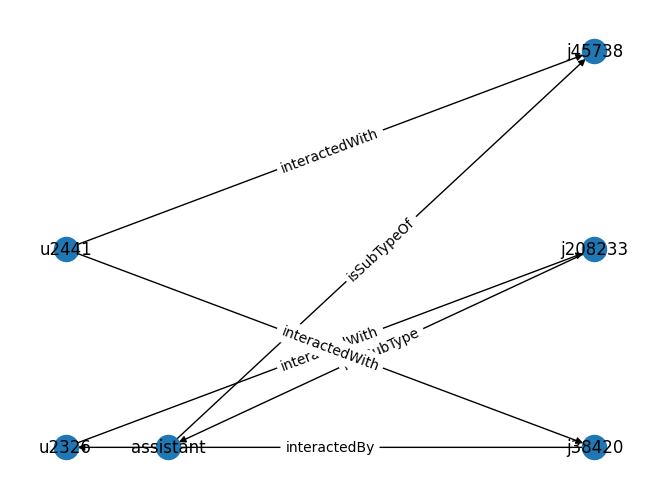

In [135]:
# for each of the parts create a set 
nodes_0  = set([n for n in graph.nodes if n in set(actions["user_id"].values)])
# nodes_1  = set([n for n in graph.nodes if n in set(translated.values())])
nodes_2  = set([n for n in graph.nodes if n in set(actions["jd_no"].values)])

# set the location of the nodes for each set
pos = dict()
pos.update( (n, (1, i)) for i, n in enumerate(nodes_0) ) # put nodes from X at x=1
pos.update( (n, (np.random.uniform(1.25, 2.75), i)) for i, n in enumerate(set(graph.nodes) - nodes_0 - nodes_2) ) # put nodes from Y at x=2
pos.update( (n, (3, i)) for i, n in enumerate(nodes_2) ) # put nodes from X at x=1

nx.draw(graph, with_labels=True, pos=pos)
nx.draw_networkx_edge_labels(graph, pos, edge_labels=nx.get_edge_attributes(graph, 'label'));

In [124]:
nx.node_link_data(graph)

{'directed': True,
 'multigraph': False,
 'graph': {},
 'nodes': [{'title': '销售年薪30万+（月薪6K+月绩效奖+高提成）', 'id': 'j222149'},
  {'id': 'director'},
  {'experience': '分析|预算|投资|电话|跟单|客户资源|核算|收益|后期|早教|招商经理|客户|旅游|全国|路线|关系|电销|财务管理|制作|旅游顾问|协助|销售业务|考察|过程|加盟|质量|销售|报价|事务',
   'id': 'u2471'},
  {'title': '店面区域经理', 'id': 'j185490'},
  {'experience': '地区|计划|互联网参考模型osi七层|员工|沟通技巧|代理商|建材|招商经理|租售|品牌|方案|领导|统计|协助|企业|户外|团队领导|经营|产品销售|驾照|商户|销售|管理体系|项目开发|分析|投资|销售工作|招商|投资人|前台|租赁|需求|后厨|反馈|核算|自我评价|沟通|宣传|饭店|收集|内容|客户|行业|合作|成本核算|规划|区域销售|关系|签约|财务管理|事业部|技巧|营销|光伏|区域|物业招商|连锁|数据|市场|产品|稳重|驾驶能力|政策|市场调研',
   'id': 'u727'},
  {'id': 'business manager'},
  {'title': '商务拓展', 'id': 'j87361'},
  {'title': 'BD', 'id': 'j182838'}],
 'links': [{'label': 'interactedBy', 'source': 'j222149', 'target': 'u727'},
  {'label': 'isSubTypeOf', 'source': 'director', 'target': 'j182838'},
  {'label': 'interactedWith', 'source': 'u2471', 'target': 'j222149'},
  {'label': 'interactedWith', 'source': 'u2471', 'target': 'j182838'},
  {'label': 'int

In [44]:
{"Nodes"   : len(G.nodes()),
 "Edges"   : len(G.edges()),
 "Density" : nx.density(G),
 "Avg degree" : np.mean(list(dict(G.degree()).values()))}

{'Nodes': 284251,
 'Edges': 1595738,
 'Density': 1.9749636770878607e-05,
 'Avg degree': 11.227668504244487}

In [45]:
len(list(nx.strongly_connected_components(G)))

59

<AxesSubplot:>

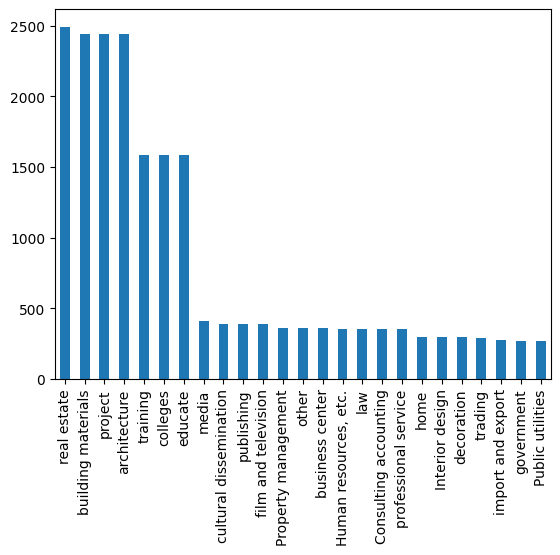

In [46]:
user_desire_industry.value_counts().head(25).plot(kind="bar")

<AxesSubplot:>

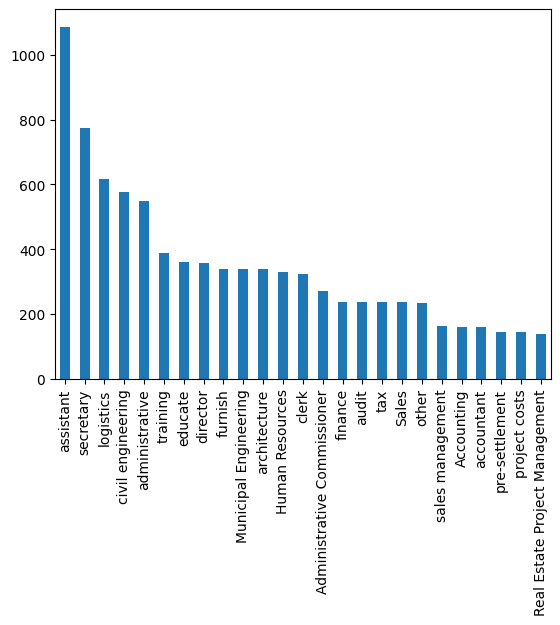

In [47]:
user_desire_type.value_counts().head(25).plot(kind="bar")

<AxesSubplot:>

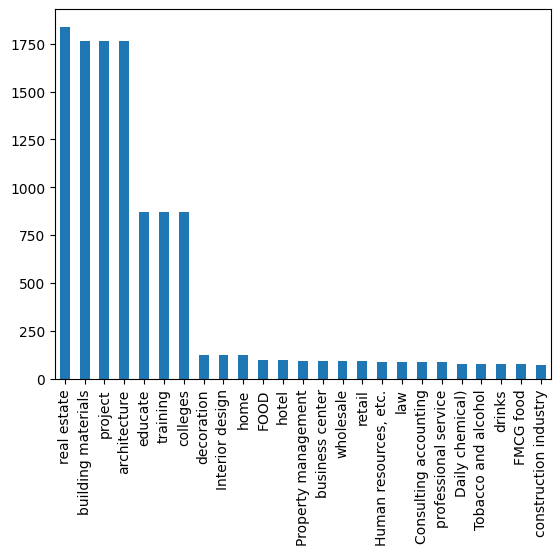

In [48]:
user_current_industry.value_counts().head(25).plot(kind="bar")

<AxesSubplot:>

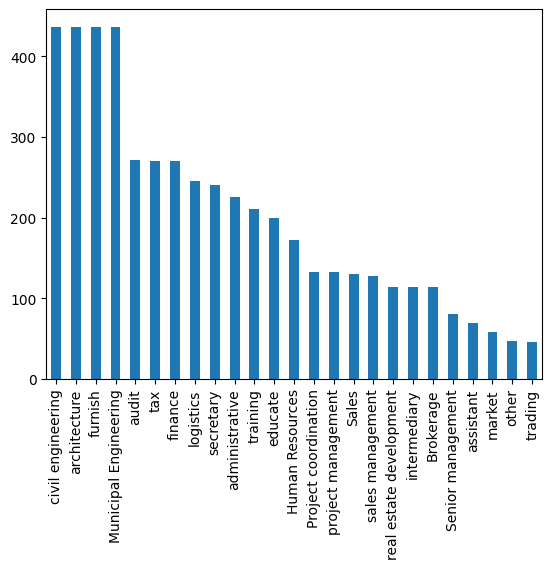

In [49]:
user_cur_type.value_counts().head(25).plot(kind="bar")

<AxesSubplot:>

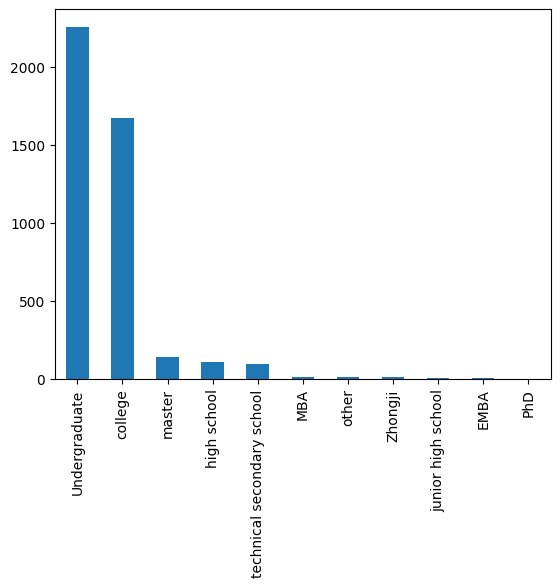

In [50]:
user_degree.value_counts().head(25).plot(kind="bar")

<AxesSubplot:>

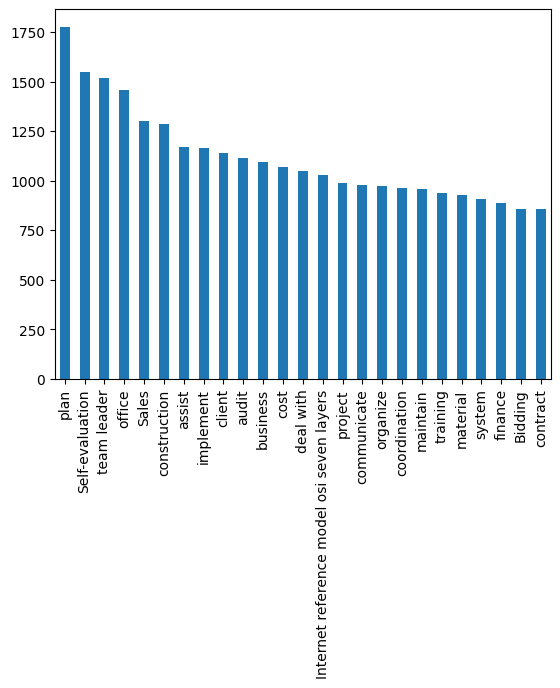

In [51]:
user_experience.value_counts().head(25).plot(kind="bar")

<AxesSubplot:>

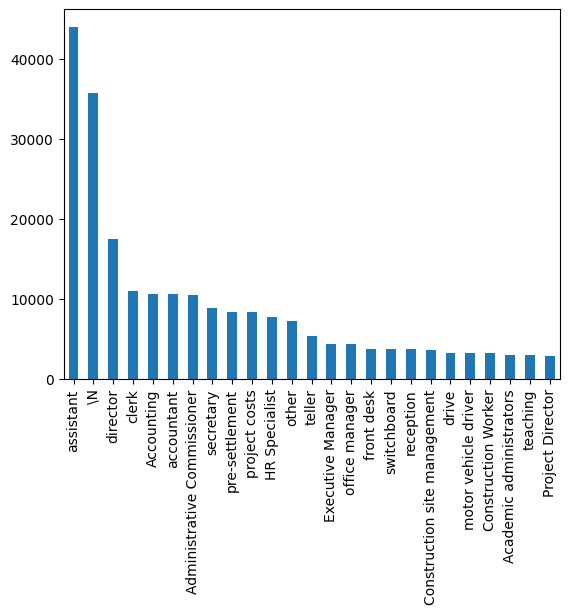

In [52]:
jds_sub_type.value_counts().head(25).plot(kind="bar")

<AxesSubplot:>

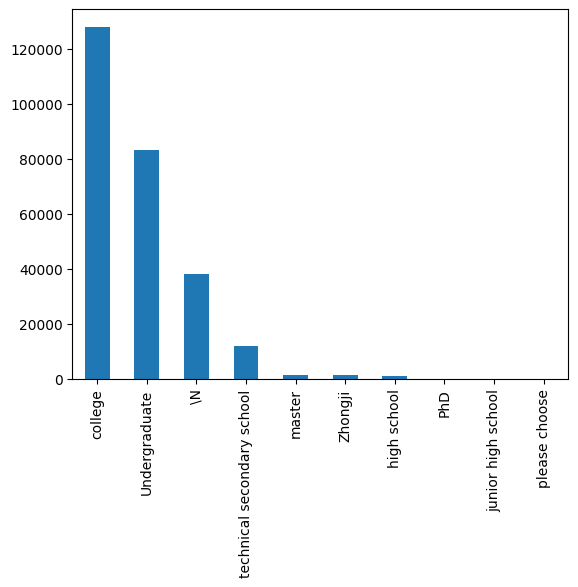

In [53]:
jds_min_degree.value_counts().head(25).plot(kind="bar")

<AxesSubplot:>

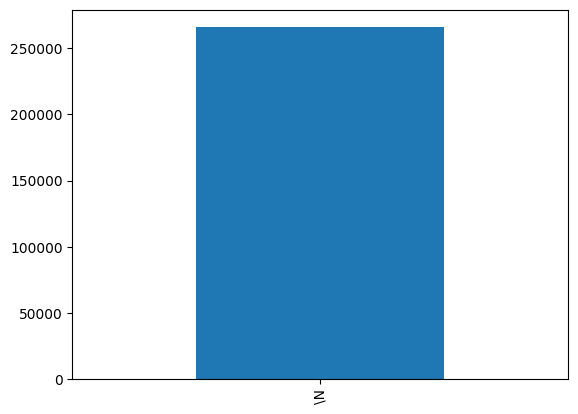

In [54]:
jds_max_degree.value_counts().head(25).plot(kind="bar")

In [55]:
jds[["jd_no", "company_name"]].set_index("jd_no").squeeze().replace('[(\（\().*\)]','', regex=True).str.split(r"[/|,、]").explode().value_counts()

-    265690
Name: company_name, dtype: int64